<a href="https://colab.research.google.com/github/anomara1/ANO_Colab_Codes/blob/main/audio_1001_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Main Packages**

In [2]:
pip install pesq pystoi

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=275940 sha256=b1d57cd6bf2740b1de844747410ca72384c71b289696272399b15899436639c8
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


# **Metrics sensitvity to noise levels**

Speech duration: 45.50 seconds
Music duration: 165.72 seconds


/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '


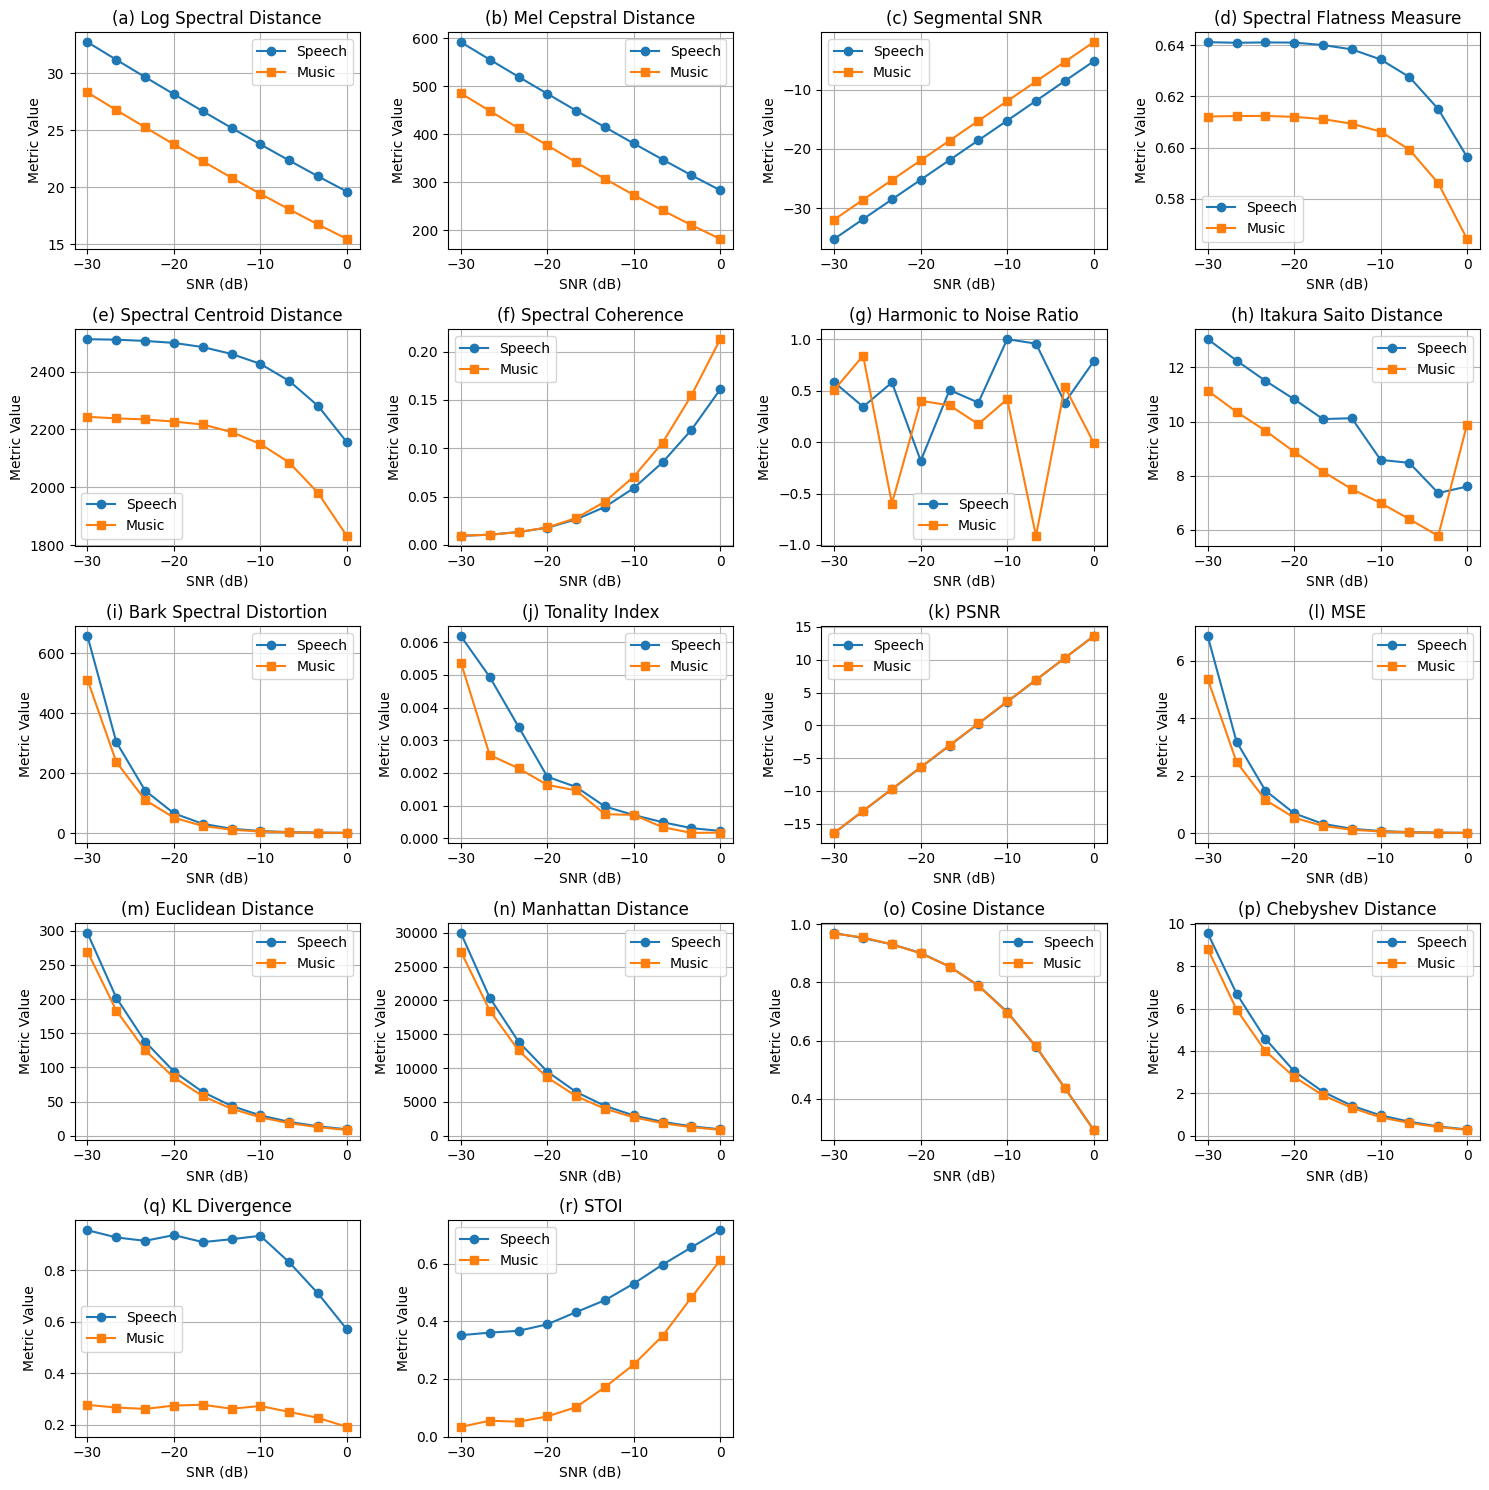

Results saved to 'audio_quality_results.xlsx' and 'audio_quality_metrics.png'.


In [ ]:
import numpy as np
import librosa
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import scipy.signal
import scipy.spatial
import scipy.stats
from scipy.linalg import norm
import pesq  # For PESQ metric
from pystoi import stoi  # For STOI metric



#from SignalMetrics import SignalMetrics
class SignalMetrics:
    def __init__(self, original, processed, sr=16000):
        """
        Initialize with original and processed signals.
        :param original: 1D numpy array of the original signal
        :param processed: 1D numpy array of the processed signal
        :param sr: Sampling rate of the signals (default 16 kHz)
        """
        self.original = original
        self.processed = processed
        self.sr = sr

    def log_spectral_distance(self):
        """Log Spectral Distance (LSD)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        lsd = np.mean((10 * np.log10(orig_spec / proc_spec)) ** 2)
        return np.sqrt(lsd)

    def mel_cepstral_distance(self):
        """Mel-Cepstral Distance (MCD)"""
        orig_mfcc = librosa.feature.mfcc(y=self.original, sr=self.sr)
        proc_mfcc = librosa.feature.mfcc(y=self.processed, sr=self.sr)
        return np.mean(np.linalg.norm(orig_mfcc - proc_mfcc, axis=0))

    def segmental_snr(self, frame_length=2048, overlap=1024):
        """Segmental Signal-to-Noise Ratio (SegSNR)"""
        orig_frames = librosa.util.frame(self.original, frame_length=frame_length, hop_length=overlap)
        proc_frames = librosa.util.frame(self.processed, frame_length=frame_length, hop_length=overlap)

        snr_list = []
        for o, p in zip(orig_frames.T, proc_frames.T):
            noise = o - p
            if np.any(o ** 2):
                snr_list.append(10 * np.log10(np.mean(o ** 2) / (np.mean(noise ** 2) + 1e-10)))

        return np.mean(snr_list) if snr_list else 0  # Avoid empty list issue

    def spectral_flatness_measure(self):
        """Spectral Flatness Measure (SFM)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        orig_sfm = scipy.stats.gmean(orig_spec, axis=0) / np.mean(orig_spec, axis=0)
        proc_sfm = scipy.stats.gmean(proc_spec, axis=0) / np.mean(proc_spec, axis=0)
        return np.mean(np.abs(orig_sfm - proc_sfm))

    def spectral_centroid_distance(self):
        """Spectral Centroid Distance"""
        orig_centroid = librosa.feature.spectral_centroid(y=self.original, sr=self.sr)
        proc_centroid = librosa.feature.spectral_centroid(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_centroid - proc_centroid))

    def spectral_coherence(self):
        """Spectral Coherence"""
        f, Cxy = scipy.signal.coherence(self.original, self.processed, fs=self.sr)
        return np.mean(Cxy)

    def harmonic_to_noise_ratio(self):
        """Harmonic-to-Noise Ratio (HNR)"""
        return librosa.effects.harmonic(self.processed).mean() / librosa.effects.percussive(self.processed).mean()

    def itakura_saito_distance(self):
        """Itakura-Saito Distance"""
        orig_psd = np.abs(librosa.stft(self.original)) ** 2
        proc_psd = np.abs(librosa.stft(self.processed)) ** 2
        return np.mean(orig_psd / proc_psd - np.log(orig_psd / proc_psd) - 1)

    def bark_spectral_distortion(self):
        """Bark Spectral Distortion (Approximated using Mel-frequency)"""
        orig_mel = librosa.feature.melspectrogram(y=self.original, sr=self.sr)
        proc_mel = librosa.feature.melspectrogram(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_mel - proc_mel))

    def tonality_index(self):
        """Tonality Index (Ratio of Harmonic Energy to Total Energy)"""
        orig_harmonic = librosa.effects.harmonic(self.original)
        proc_harmonic = librosa.effects.harmonic(self.processed)
        return np.abs(np.mean(orig_harmonic) - np.mean(proc_harmonic))

    def psnr(self):
        """Peak Signal-to-Noise Ratio (PSNR)"""
        mse_val = self.mse()
        max_val = np.max(self.original) ** 2
        return 10 * np.log10(max_val / (mse_val + 1e-10))

    def mse(self):
        """Mean Squared Error (MSE)"""
        return np.mean((self.original - self.processed) ** 2)

    def euclidean_distance(self):
        """Euclidean Distance"""
        return np.linalg.norm(self.original - self.processed)

    def manhattan_distance(self):
        """Manhattan Distance"""
        return np.sum(np.abs(self.original - self.processed))

    def cosine_distance(self):
        """Cosine Distance"""
        return scipy.spatial.distance.cosine(self.original, self.processed)

    def chebyshev_distance(self):
        """Chebyshev Distance"""
        return np.max(np.abs(self.original - self.processed))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def kl_divergence(self):
        """Kullback-Leibler (KL) Divergence"""
        orig_hist = np.histogram(self.original, bins=256, density=True)[0] + 1e-10
        proc_hist = np.histogram(self.processed, bins=256, density=True)[0] + 1e-10
        return scipy.stats.entropy(orig_hist, proc_hist)

    def pesq(self):
        """Perceptual Evaluation of Speech Quality (PESQ)"""
        # PESQ requires signals to be resampled to 16 kHz or 8 kHz
        if self.sr not in [8000, 16000]:
            raise ValueError("PESQ requires sampling rate of 8000 Hz or 16000 Hz.")
        return pesq.pesq(self.sr, self.original, self.processed, 'wb')  # 'wb' for wideband

    def stoi(self):
        """Short-Time Objective Intelligibility (STOI)"""
        return stoi(self.original, self.processed, self.sr, extended=False)

    def compute_all_metrics(self):
        """Compute all metrics"""
        return {
            'Log Spectral Distance': self.log_spectral_distance(),
            'Mel Cepstral Distance': self.mel_cepstral_distance(),
            'Segmental SNR': self.segmental_snr(),
            'Spectral Flatness Measure': self.spectral_flatness_measure(),
            'Spectral Centroid Distance': self.spectral_centroid_distance(),
            'Spectral Coherence': self.spectral_coherence(),
            'Harmonic to Noise Ratio': self.harmonic_to_noise_ratio(),
            'Itakura Saito Distance': self.itakura_saito_distance(),
            'Bark Spectral Distortion': self.bark_spectral_distortion(),
            'Tonality Index': self.tonality_index(),
            'PSNR': self.psnr(),
            'MSE': self.mse(),
            'Euclidean Distance': self.euclidean_distance(),
            'Manhattan Distance': self.manhattan_distance(),
            'Cosine Distance': self.cosine_distance(),
            'Chebyshev Distance': self.chebyshev_distance(),
            #'Shannon Entropy': self.shannon_entropy(self.processed),
            'KL Divergence': self.kl_divergence(),
            #'PESQ': self.pesq(),
            'STOI': self.stoi()
        }



#import librosa
import numpy as np

# Load speech and music datasets
speech1, sr = librosa.load(librosa.example('libri1'), sr=16000)
speech2, _ = librosa.load(librosa.example('libri2'), sr=16000)  # Another speech file
speech3, _ = librosa.load(librosa.example('libri3'), sr=16000)
#speech4, _ = librosa.load(librosa.example('libri4'), sr=16000)  # Another speech file
music1, _ = librosa.load(librosa.example('brahms'), sr=16000)
music2, _ = librosa.load(librosa.example('nutcracker'), sr=16000)  # Another music file

# Concatenate audio files to ensure enough duration
speech = np.concatenate([speech1, speech2, speech3])
music = np.concatenate([music1, music2])

# Check duration after concatenation
speech_duration = len(speech) / sr
music_duration = len(music) / sr

if speech_duration < 45 or music_duration < 45:
    raise ValueError("Not enough data in the combined speech or music datasets.")

print(f"Speech duration: {speech_duration:.2f} seconds")
print(f"Music duration: {music_duration:.2f} seconds")


# Extract valid 1-second segments
speech_segments = [speech[i * sr:(i + 1) * sr] for i in range(45) if len(speech[i * sr:(i + 1) * sr]) == sr]
music_segments = [music[i * sr:(i + 1) * sr] for i in range(45) if len(music[i * sr:(i + 1) * sr]) == sr]

# If any segment list is too short, report an error
if len(speech_segments) < 45 or len(music_segments) < 45:
    raise ValueError("Error: Some 1-second segments are empty or too short.")

# Define noise levels in dB
snr_levels = np.linspace(-30, 0, 10)

# Store results
metric_names = list(SignalMetrics(speech_segments[0], speech_segments[0]).compute_all_metrics().keys())
speech_results = {metric: [] for metric in metric_names}
music_results = {metric: [] for metric in metric_names}
time_consumption = {metric: [] for metric in metric_names}

# Function to add white Gaussian noise
def add_noise(signal, snr_db):
    """Adds white Gaussian noise to a signal at the given SNR level."""
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.sqrt(noise_power) * np.random.randn(len(signal))
    return signal + noise

# Iterate over SNR levels
for snr in snr_levels:
    speech_avg_metrics = {metric: 0 for metric in metric_names}
    music_avg_metrics = {metric: 0 for metric in metric_names}
    time_avg_metrics = {metric: 0 for metric in metric_names}

    for orig_speech, orig_music in zip(speech_segments, music_segments):
        noisy_speech = add_noise(orig_speech, snr)
        noisy_music = add_noise(orig_music, snr)

        speech_metrics = SignalMetrics(orig_speech, noisy_speech, sr)
        music_metrics = SignalMetrics(orig_music, noisy_music, sr)

        for metric in metric_names:
            start_time = time.time()
            try:
                speech_value = getattr(speech_metrics, metric.lower().replace(" ", "_"))()
                music_value = getattr(music_metrics, metric.lower().replace(" ", "_"))()
            except Exception as e:
                #print(f"Error in metric {metric}: {e}")
                speech_value, music_value = np.nan, np.nan  # Store NaN if error occurs

            elapsed_time = time.time() - start_time

            speech_avg_metrics[metric] += speech_value / 45
            music_avg_metrics[metric] += music_value / 45
            time_avg_metrics[metric] += elapsed_time / 45

    # Store averaged results
    for metric in metric_names:
        speech_results[metric].append(speech_avg_metrics[metric])
        music_results[metric].append(music_avg_metrics[metric])
        time_consumption[metric].append(time_avg_metrics[metric])

# Plot results (Only create necessary subplots)
num_metrics = len(metric_names)
rows = (num_metrics // 4) + (1 if num_metrics % 4 else 0)  # Calculate required rows
fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(15, rows * 3))
axes = axes.flatten()

for i, metric in enumerate(metric_names):
    ax = axes[i]
    ax.plot(snr_levels, speech_results[metric], marker='o', label='Speech')
    ax.plot(snr_levels, music_results[metric], marker='s', label='Music')
    ax.set_title(f"({chr(97 + i)}) {metric}")
    ax.set_xlabel("SNR (dB)")
    ax.set_ylabel("Metric Value")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("audio_quality_metrics.png")
plt.show()


# Export results to Excel
df_speech = pd.DataFrame(speech_results, index=snr_levels)
df_music = pd.DataFrame(music_results, index=snr_levels)
df_time = pd.DataFrame(time_consumption, index=snr_levels)

with pd.ExcelWriter("audio_quality_results.xlsx") as writer:
    df_speech.to_excel(writer, sheet_name="Speech Metrics")
    df_music.to_excel(writer, sheet_name="Music Metrics")
    df_time.to_excel(writer, sheet_name="Time Consumption")

print("Results saved to 'audio_quality_results.xlsx' and 'audio_quality_metrics.png'.")


Speech duration: 45.50 seconds
Music duration: 165.72 seconds


/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '


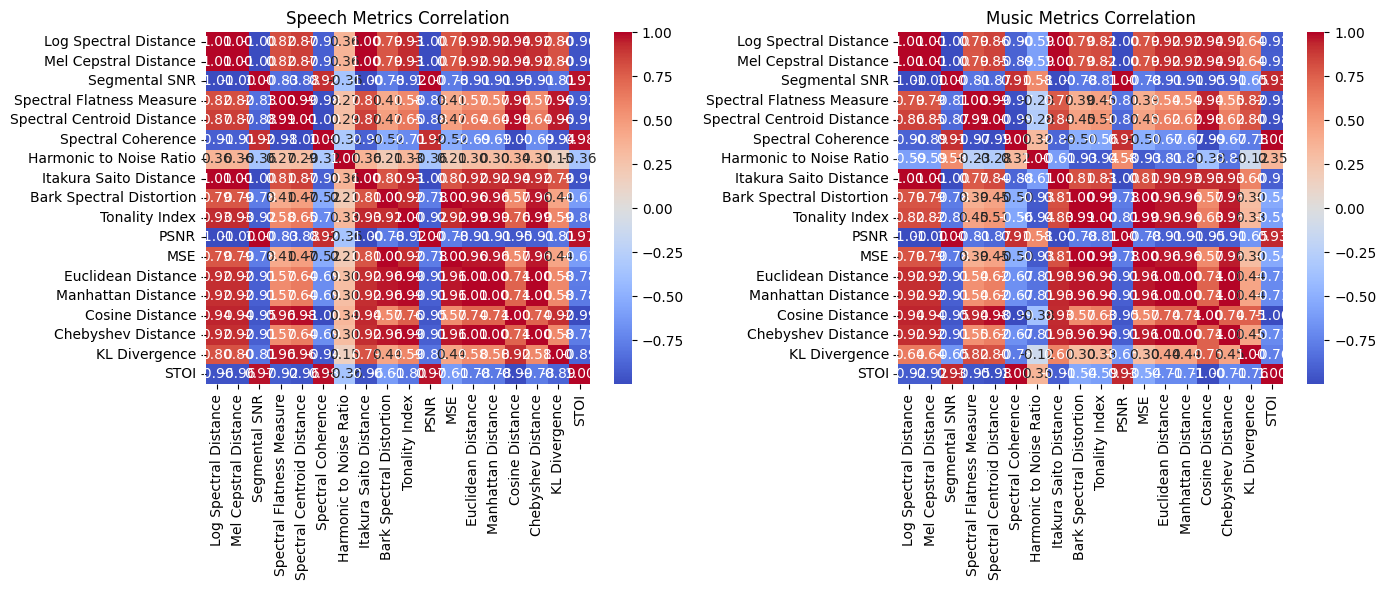

In [6]:
import numpy as np
import librosa
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import scipy.signal
import scipy.spatial
import scipy.stats
from scipy.linalg import norm
import pesq  # For PESQ metric
from pystoi import stoi  # For STOI metric



#from SignalMetrics import SignalMetrics
class SignalMetrics:
    def __init__(self, original, processed, sr=16000):
        """
        Initialize with original and processed signals.
        :param original: 1D numpy array of the original signal
        :param processed: 1D numpy array of the processed signal
        :param sr: Sampling rate of the signals (default 16 kHz)
        """
        self.original = original
        self.processed = processed
        self.sr = sr

    def log_spectral_distance(self):
        """Log Spectral Distance (LSD)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        lsd = np.mean((10 * np.log10(orig_spec / proc_spec)) ** 2)
        return np.sqrt(lsd)

    def mel_cepstral_distance(self):
        """Mel-Cepstral Distance (MCD)"""
        orig_mfcc = librosa.feature.mfcc(y=self.original, sr=self.sr)
        proc_mfcc = librosa.feature.mfcc(y=self.processed, sr=self.sr)
        return np.mean(np.linalg.norm(orig_mfcc - proc_mfcc, axis=0))

    def segmental_snr(self, frame_length=2048, overlap=1024):
        """Segmental Signal-to-Noise Ratio (SegSNR)"""
        orig_frames = librosa.util.frame(self.original, frame_length=frame_length, hop_length=overlap)
        proc_frames = librosa.util.frame(self.processed, frame_length=frame_length, hop_length=overlap)

        snr_list = []
        for o, p in zip(orig_frames.T, proc_frames.T):
            noise = o - p
            if np.any(o ** 2):
                snr_list.append(10 * np.log10(np.mean(o ** 2) / (np.mean(noise ** 2) + 1e-10)))

        return np.mean(snr_list) if snr_list else 0  # Avoid empty list issue

    def spectral_flatness_measure(self):
        """Spectral Flatness Measure (SFM)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        orig_sfm = scipy.stats.gmean(orig_spec, axis=0) / np.mean(orig_spec, axis=0)
        proc_sfm = scipy.stats.gmean(proc_spec, axis=0) / np.mean(proc_spec, axis=0)
        return np.mean(np.abs(orig_sfm - proc_sfm))

    def spectral_centroid_distance(self):
        """Spectral Centroid Distance"""
        orig_centroid = librosa.feature.spectral_centroid(y=self.original, sr=self.sr)
        proc_centroid = librosa.feature.spectral_centroid(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_centroid - proc_centroid))

    def spectral_coherence(self):
        """Spectral Coherence"""
        f, Cxy = scipy.signal.coherence(self.original, self.processed, fs=self.sr)
        return np.mean(Cxy)

    def harmonic_to_noise_ratio(self):
        """Harmonic-to-Noise Ratio (HNR)"""
        return librosa.effects.harmonic(self.processed).mean() / librosa.effects.percussive(self.processed).mean()

    def itakura_saito_distance(self):
        """Itakura-Saito Distance"""
        orig_psd = np.abs(librosa.stft(self.original)) ** 2
        proc_psd = np.abs(librosa.stft(self.processed)) ** 2
        return np.mean(orig_psd / proc_psd - np.log(orig_psd / proc_psd) - 1)

    def bark_spectral_distortion(self):
        """Bark Spectral Distortion (Approximated using Mel-frequency)"""
        orig_mel = librosa.feature.melspectrogram(y=self.original, sr=self.sr)
        proc_mel = librosa.feature.melspectrogram(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_mel - proc_mel))

    def tonality_index(self):
        """Tonality Index (Ratio of Harmonic Energy to Total Energy)"""
        orig_harmonic = librosa.effects.harmonic(self.original)
        proc_harmonic = librosa.effects.harmonic(self.processed)
        return np.abs(np.mean(orig_harmonic) - np.mean(proc_harmonic))

    def psnr(self):
        """Peak Signal-to-Noise Ratio (PSNR)"""
        mse_val = self.mse()
        max_val = np.max(self.original) ** 2
        return 10 * np.log10(max_val / (mse_val + 1e-10))

    def mse(self):
        """Mean Squared Error (MSE)"""
        return np.mean((self.original - self.processed) ** 2)

    def euclidean_distance(self):
        """Euclidean Distance"""
        return np.linalg.norm(self.original - self.processed)

    def manhattan_distance(self):
        """Manhattan Distance"""
        return np.sum(np.abs(self.original - self.processed))

    def cosine_distance(self):
        """Cosine Distance"""
        return scipy.spatial.distance.cosine(self.original, self.processed)

    def chebyshev_distance(self):
        """Chebyshev Distance"""
        return np.max(np.abs(self.original - self.processed))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def kl_divergence(self):
        """Kullback-Leibler (KL) Divergence"""
        orig_hist = np.histogram(self.original, bins=256, density=True)[0] + 1e-10
        proc_hist = np.histogram(self.processed, bins=256, density=True)[0] + 1e-10
        return scipy.stats.entropy(orig_hist, proc_hist)

    def pesq(self):
        """Perceptual Evaluation of Speech Quality (PESQ)"""
        # PESQ requires signals to be resampled to 16 kHz or 8 kHz
        if self.sr not in [8000, 16000]:
            raise ValueError("PESQ requires sampling rate of 8000 Hz or 16000 Hz.")
        return pesq.pesq(self.sr, self.original, self.processed, 'wb')  # 'wb' for wideband

    def stoi(self):
        """Short-Time Objective Intelligibility (STOI)"""
        return stoi(self.original, self.processed, self.sr, extended=False)

    def compute_all_metrics(self):
        """Compute all metrics"""
        return {
            'Log Spectral Distance': self.log_spectral_distance(),
            'Mel Cepstral Distance': self.mel_cepstral_distance(),
            'Segmental SNR': self.segmental_snr(),
            'Spectral Flatness Measure': self.spectral_flatness_measure(),
            'Spectral Centroid Distance': self.spectral_centroid_distance(),
            'Spectral Coherence': self.spectral_coherence(),
            'Harmonic to Noise Ratio': self.harmonic_to_noise_ratio(),
            'Itakura Saito Distance': self.itakura_saito_distance(),
            'Bark Spectral Distortion': self.bark_spectral_distortion(),
            'Tonality Index': self.tonality_index(),
            'PSNR': self.psnr(),
            'MSE': self.mse(),
            'Euclidean Distance': self.euclidean_distance(),
            'Manhattan Distance': self.manhattan_distance(),
            'Cosine Distance': self.cosine_distance(),
            'Chebyshev Distance': self.chebyshev_distance(),
            #'Shannon Entropy': self.shannon_entropy(self.processed),
            'KL Divergence': self.kl_divergence(),
            #'PESQ': self.pesq(),
            'STOI': self.stoi()
        }



#import librosa
import numpy as np

# Load speech and music datasets
speech1, sr = librosa.load(librosa.example('libri1'), sr=16000)
speech2, _ = librosa.load(librosa.example('libri2'), sr=16000)  # Another speech file
speech3, _ = librosa.load(librosa.example('libri3'), sr=16000)
#speech4, _ = librosa.load(librosa.example('libri4'), sr=16000)  # Another speech file
music1, _ = librosa.load(librosa.example('brahms'), sr=16000)
music2, _ = librosa.load(librosa.example('nutcracker'), sr=16000)  # Another music file

# Concatenate audio files to ensure enough duration
speech = np.concatenate([speech1, speech2, speech3])
music = np.concatenate([music1, music2])

# Check duration after concatenation
speech_duration = len(speech) / sr
music_duration = len(music) / sr

if speech_duration < 45 or music_duration < 45:
    raise ValueError("Not enough data in the combined speech or music datasets.")

print(f"Speech duration: {speech_duration:.2f} seconds")
print(f"Music duration: {music_duration:.2f} seconds")


# Extract valid 1-second segments
speech_segments = [speech[i * sr:(i + 1) * sr] for i in range(45) if len(speech[i * sr:(i + 1) * sr]) == sr]
music_segments = [music[i * sr:(i + 1) * sr] for i in range(45) if len(music[i * sr:(i + 1) * sr]) == sr]

# If any segment list is too short, report an error
if len(speech_segments) < 45 or len(music_segments) < 45:
    raise ValueError("Error: Some 1-second segments are empty or too short.")

# Define noise levels in dB
snr_levels = np.linspace(-30, 0, 10)

# Store results
metric_names = list(SignalMetrics(speech_segments[0], speech_segments[0]).compute_all_metrics().keys())
speech_results = {metric: [] for metric in metric_names}
music_results = {metric: [] for metric in metric_names}
time_consumption = {metric: [] for metric in metric_names}

# Function to add white Gaussian noise
def add_noise(signal, snr_db):
    """Adds white Gaussian noise to a signal at the given SNR level."""
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.sqrt(noise_power) * np.random.randn(len(signal))
    return signal + noise

# Iterate over SNR levels
for snr in snr_levels:
    speech_avg_metrics = {metric: 0 for metric in metric_names}
    music_avg_metrics = {metric: 0 for metric in metric_names}
    time_avg_metrics = {metric: 0 for metric in metric_names}

    for orig_speech, orig_music in zip(speech_segments, music_segments):
        noisy_speech = add_noise(orig_speech, snr)
        noisy_music = add_noise(orig_music, snr)

        speech_metrics = SignalMetrics(orig_speech, noisy_speech, sr)
        music_metrics = SignalMetrics(orig_music, noisy_music, sr)

        for metric in metric_names:
            start_time = time.time()
            try:
                speech_value = getattr(speech_metrics, metric.lower().replace(" ", "_"))()
                music_value = getattr(music_metrics, metric.lower().replace(" ", "_"))()
            except Exception as e:
                #print(f"Error in metric {metric}: {e}")
                speech_value, music_value = np.nan, np.nan  # Store NaN if error occurs

            elapsed_time = time.time() - start_time

            speech_avg_metrics[metric] += speech_value / 45
            music_avg_metrics[metric] += music_value / 45
            time_avg_metrics[metric] += elapsed_time / 45

    # Store averaged results
    for metric in metric_names:
        speech_results[metric].append(speech_avg_metrics[metric])
        music_results[metric].append(music_avg_metrics[metric])
        time_consumption[metric].append(time_avg_metrics[metric])

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results to DataFrame
df_speech = pd.DataFrame(speech_results, index=snr_levels)
df_music = pd.DataFrame(music_results, index=snr_levels)

# Compute correlation matrices
corr_speech = df_speech.corr()
corr_music = df_music.corr()

# Plot correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(corr_speech, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("Speech Metrics Correlation")
sns.heatmap(corr_music, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("Music Metrics Correlation")

plt.tight_layout()
plt.savefig("correlation_matrices.png")
plt.show()

# Export correlation matrices to Excel
with pd.ExcelWriter("audio_metrics_correlation.xlsx") as writer:
    corr_speech.to_excel(writer, sheet_name="Speech Correlation")
    corr_music.to_excel(writer, sheet_name="Music Correlation")



In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy.signal
import scipy.spatial
import time
import matplotlib.pyplot as plt
import librosa

# Define the SignalMetrics class with various audio quality metrics
class SignalMetrics:
    def __init__(self, original, processed, sr=16000):
        """
        Initialize with original and processed signals.
        :param original: 1D numpy array of the original signal
        :param processed: 1D numpy array of the processed signal
        :param sr: Sampling rate of the signals (default 16 kHz)
        """
        self.original = original
        self.processed = processed
        self.sr = sr

    def log_spectral_distance(self):
        """Log Spectral Distance (LSD)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        lsd = np.mean((10 * np.log10(orig_spec / proc_spec)) ** 2)
        return np.sqrt(lsd)

    def mel_cepstral_distance(self):
        """Mel-Cepstral Distance (MCD)"""
        orig_mfcc = librosa.feature.mfcc(y=self.original, sr=self.sr)
        proc_mfcc = librosa.feature.mfcc(y=self.processed, sr=self.sr)
        return np.mean(np.linalg.norm(orig_mfcc - proc_mfcc, axis=0))

    def segmental_snr(self, frame_length=2048, overlap=1024):
        """Segmental Signal-to-Noise Ratio (SegSNR)"""
        orig_frames = librosa.util.frame(self.original, frame_length=frame_length, hop_length=overlap)
        proc_frames = librosa.util.frame(self.processed, frame_length=frame_length, hop_length=overlap)

        snr_list = []
        for o, p in zip(orig_frames.T, proc_frames.T):
            noise = o - p
            if np.any(o ** 2):
                snr_list.append(10 * np.log10(np.mean(o ** 2) / (np.mean(noise ** 2) + 1e-10)))

        return np.mean(snr_list) if snr_list else 0

    def spectral_flatness_measure(self):
        """Spectral Flatness Measure (SFM)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        orig_sfm = scipy.stats.gmean(orig_spec, axis=0) / np.mean(orig_spec, axis=0)
        proc_sfm = scipy.stats.gmean(proc_spec, axis=0) / np.mean(proc_spec, axis=0)
        return np.mean(np.abs(orig_sfm - proc_sfm))

    def spectral_centroid_distance(self):
        """Spectral Centroid Distance"""
        orig_centroid = librosa.feature.spectral_centroid(y=self.original, sr=self.sr)
        proc_centroid = librosa.feature.spectral_centroid(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_centroid - proc_centroid))

    def spectral_coherence(self):
        """Spectral Coherence"""
        f, Cxy = scipy.signal.coherence(self.original, self.processed, fs=self.sr)
        return np.mean(Cxy)

    def harmonic_to_noise_ratio(self):
        """Harmonic-to-Noise Ratio (HNR)"""
        return librosa.effects.harmonic(self.processed).mean() / librosa.effects.percussive(self.processed).mean()

    def itakura_saito_distance(self):
        """Itakura-Saito Distance"""
        orig_psd = np.abs(librosa.stft(self.original)) ** 2
        proc_psd = np.abs(librosa.stft(self.processed)) ** 2
        return np.mean(orig_psd / proc_psd - np.log(orig_psd / proc_psd) - 1)

    def bark_spectral_distortion(self):
        """Bark Spectral Distortion (Approximated using Mel-frequency)"""
        orig_mel = librosa.feature.melspectrogram(y=self.original, sr=self.sr)
        proc_mel = librosa.feature.melspectrogram(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_mel - proc_mel))

    def tonality_index(self):
        """Tonality Index (Ratio of Harmonic Energy to Total Energy)"""
        orig_harmonic = librosa.effects.harmonic(self.original)
        proc_harmonic = librosa.effects.harmonic(self.processed)
        return np.abs(np.mean(orig_harmonic) - np.mean(proc_harmonic))

    def psnr(self):
        """Peak Signal-to-Noise Ratio (PSNR)"""
        mse_val = self.mse()
        max_val = np.max(self.original) ** 2
        return 10 * np.log10(max_val / (mse_val + 1e-10))

    def mse(self):
        """Mean Squared Error (MSE)"""
        return np.mean((self.original - self.processed) ** 2)

    def euclidean_distance(self):
        """Euclidean Distance"""
        return np.linalg.norm(self.original - self.processed)

    def manhattan_distance(self):
        """Manhattan Distance"""
        return np.sum(np.abs(self.original - self.processed))

    def cosine_distance(self):
        """Cosine Distance"""
        return scipy.spatial.distance.cosine(self.original, self.processed)

    def chebyshev_distance(self):
        """Chebyshev Distance"""
        return np.max(np.abs(self.original - self.processed))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def kl_divergence(self):
        """Kullback-Leibler (KL) Divergence"""
        orig_hist = np.histogram(self.original, bins=256, density=True)[0] + 1e-10
        proc_hist = np.histogram(self.processed, bins=256, density=True)[0] + 1e-10
        return scipy.stats.entropy(orig_hist, proc_hist)

    def pesq(self):
        """Perceptual Evaluation of Speech Quality (PESQ)"""
        # PESQ requires signals to be resampled to 16 kHz or 8 kHz
        if self.sr not in [8000, 16000]:
            raise ValueError("PESQ requires sampling rate of 8000 Hz or 16000 Hz.")
        import pesq  # Import here if needed
        return pesq.pesq(self.sr, self.original, self.processed, 'wb')  # 'wb' for wideband

    def stoi(self):
        """Short-Time Objective Intelligibility (STOI)"""
        from pystoi import stoi  # Import here if needed
        return stoi(self.original, self.processed, self.sr, extended=False)

    def compute_all_metrics(self):
        """Compute all metrics"""
        return {
            'Log Spectral Distance': self.log_spectral_distance(),
            'Mel Cepstral Distance': self.mel_cepstral_distance(),
            'Segmental SNR': self.segmental_snr(),
            'Spectral Flatness Measure': self.spectral_flatness_measure(),
            'Spectral Centroid Distance': self.spectral_centroid_distance(),
            'Spectral Coherence': self.spectral_coherence(),
            'Harmonic to Noise Ratio': self.harmonic_to_noise_ratio(),
            'Itakura Saito Distance': self.itakura_saito_distance(),
            'Bark Spectral Distortion': self.bark_spectral_distortion(),
            'Tonality Index': self.tonality_index(),
            'PSNR': self.psnr(),
            'MSE': self.mse(),
            'Euclidean Distance': self.euclidean_distance(),
            'Manhattan Distance': self.manhattan_distance(),
            'Cosine Distance': self.cosine_distance(),
            'Chebyshev Distance': self.chebyshev_distance(),
            #'Shannon Entropy': self.shannon_entropy(self.processed),
            'KL Divergence': self.kl_divergence(),
            #'PESQ': self.pesq(),
            'STOI': self.stoi()
        }

# -------------------- Data Preparation --------------------
# Load speech and music datasets
speech1, sr = librosa.load(librosa.example('libri1'), sr=16000)
speech2, _ = librosa.load(librosa.example('libri2'), sr=16000)
speech3, _ = librosa.load(librosa.example('libri3'), sr=16000)
music1, _ = librosa.load(librosa.example('brahms'), sr=16000)
music2, _ = librosa.load(librosa.example('nutcracker'), sr=16000)

# Concatenate to ensure enough duration
speech = np.concatenate([speech1, speech2, speech3])
music = np.concatenate([music1, music2])

speech_duration = len(speech) / sr
music_duration = len(music) / sr

if speech_duration < 45 or music_duration < 45:
    raise ValueError("Not enough data in the combined speech or music datasets.")

print(f"Speech duration: {speech_duration:.2f} seconds")
print(f"Music duration: {music_duration:.2f} seconds")

# Extract valid 1-second segments
speech_segments = [speech[i * sr:(i + 1) * sr] for i in range(45) if len(speech[i * sr:(i + 1) * sr]) == sr]
music_segments = [music[i * sr:(i + 1) * sr] for i in range(45) if len(music[i * sr:(i + 1) * sr]) == sr]

if len(speech_segments) < 45 or len(music_segments) < 45:
    raise ValueError("Error: Some 1-second segments are empty or too short.")

# Define noise levels in dB
snr_levels = np.linspace(-30, 0, 10)

# Initialize dictionaries to store metric results and computation times
metric_names = list(SignalMetrics(speech_segments[0], speech_segments[0]).compute_all_metrics().keys())
speech_results = {metric: [] for metric in metric_names}
music_results = {metric: [] for metric in metric_names}
time_consumption = {metric: [] for metric in metric_names}

# Function to add white Gaussian noise
def add_noise(signal, snr_db):
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.sqrt(noise_power) * np.random.randn(len(signal))
    return signal + noise

# -------------------- Compute Metrics at Various Noise Levels --------------------
for snr in snr_levels:
    speech_avg_metrics = {metric: 0 for metric in metric_names}
    music_avg_metrics = {metric: 0 for metric in metric_names}
    time_avg_metrics = {metric: 0 for metric in metric_names}

    for orig_speech, orig_music in zip(speech_segments, music_segments):
        noisy_speech = add_noise(orig_speech, snr)
        noisy_music = add_noise(orig_music, snr)

        speech_metrics = SignalMetrics(orig_speech, noisy_speech, sr)
        music_metrics = SignalMetrics(orig_music, noisy_music, sr)

        for metric in metric_names:
            start_time = time.time()
            try:
                speech_value = getattr(speech_metrics, metric.lower().replace(" ", "_"))()
                music_value = getattr(music_metrics, metric.lower().replace(" ", "_"))()
            except Exception as e:
                speech_value, music_value = np.nan, np.nan
            elapsed_time = time.time() - start_time

            speech_avg_metrics[metric] += speech_value / 45
            music_avg_metrics[metric] += music_value / 45
            time_avg_metrics[metric] += elapsed_time / 45

    for metric in metric_names:
        speech_results[metric].append(speech_avg_metrics[metric])
        music_results[metric].append(music_avg_metrics[metric])
        time_consumption[metric].append(time_avg_metrics[metric])

# -------------------- Compute Clean Baseline Metrics --------------------
clean_speech = {metric: [] for metric in metric_names}
clean_music = {metric: [] for metric in metric_names}
for orig_speech, orig_music in zip(speech_segments, music_segments):
    speech_clean = SignalMetrics(orig_speech, orig_speech, sr).compute_all_metrics()
    music_clean = SignalMetrics(orig_music, orig_music, sr).compute_all_metrics()
    for metric in metric_names:
        clean_speech[metric].append(speech_clean[metric])
        clean_music[metric].append(music_clean[metric])

clean_speech_baseline = {metric: np.mean(values) for metric, values in clean_speech.items()}
clean_music_baseline = {metric: np.mean(values) for metric, values in clean_music.items()}

# -------------------- Analyze Stability and Robustness --------------------
def analyze_metrics(metrics_data, baseline):
    stability_results = {}
    robustness_results = {}
    for metric, values in metrics_data.items():
        # Stability: Standard deviation of metric values across SNR levels
        stability_results[metric] = np.std(values)
        # Robustness: Average relative deviation from the clean baseline (% change)
        if baseline[metric] == 0:
            robustness_results[metric] = np.nan
        else:
            robustness_results[metric] = np.mean(np.abs((np.array(values) - baseline[metric]) / baseline[metric])) * 100
    return stability_results, robustness_results

speech_stability, speech_robustness = analyze_metrics(speech_results, clean_speech_baseline)
music_stability, music_robustness = analyze_metrics(music_results, clean_music_baseline)

# -------------------- Visualization --------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
speech_df = pd.DataFrame({'Stability (STD)': speech_stability, 'Robustness (%)': speech_robustness})
music_df = pd.DataFrame({'Stability (STD)': music_stability, 'Robustness (%)': music_robustness})

speech_df.plot(kind='bar', ax=axes[0], title='Speech Metrics: Stability & Robustness')
music_df.plot(kind='bar', ax=axes[1], title='Music Metrics: Stability & Robustness')
plt.tight_layout()
plt.show()

# -------------------- Export Results --------------------
with pd.ExcelWriter("stability_robustness_results.xlsx") as writer:
    speech_df.to_excel(writer, sheet_name="Speech Stability & Robustness")
    music_df.to_excel(writer, sheet_name="Music Stability & Robustness")

print("Stability and Robustness analysis complete. Results saved to 'stability_robustness_results.xlsx'.")


Speech duration: 45.50 seconds
Music duration: 165.72 seconds


ModuleNotFoundError: No module named 'pystoi'

# **Metrics sensitivity to Reverb Decay Factor**

/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure

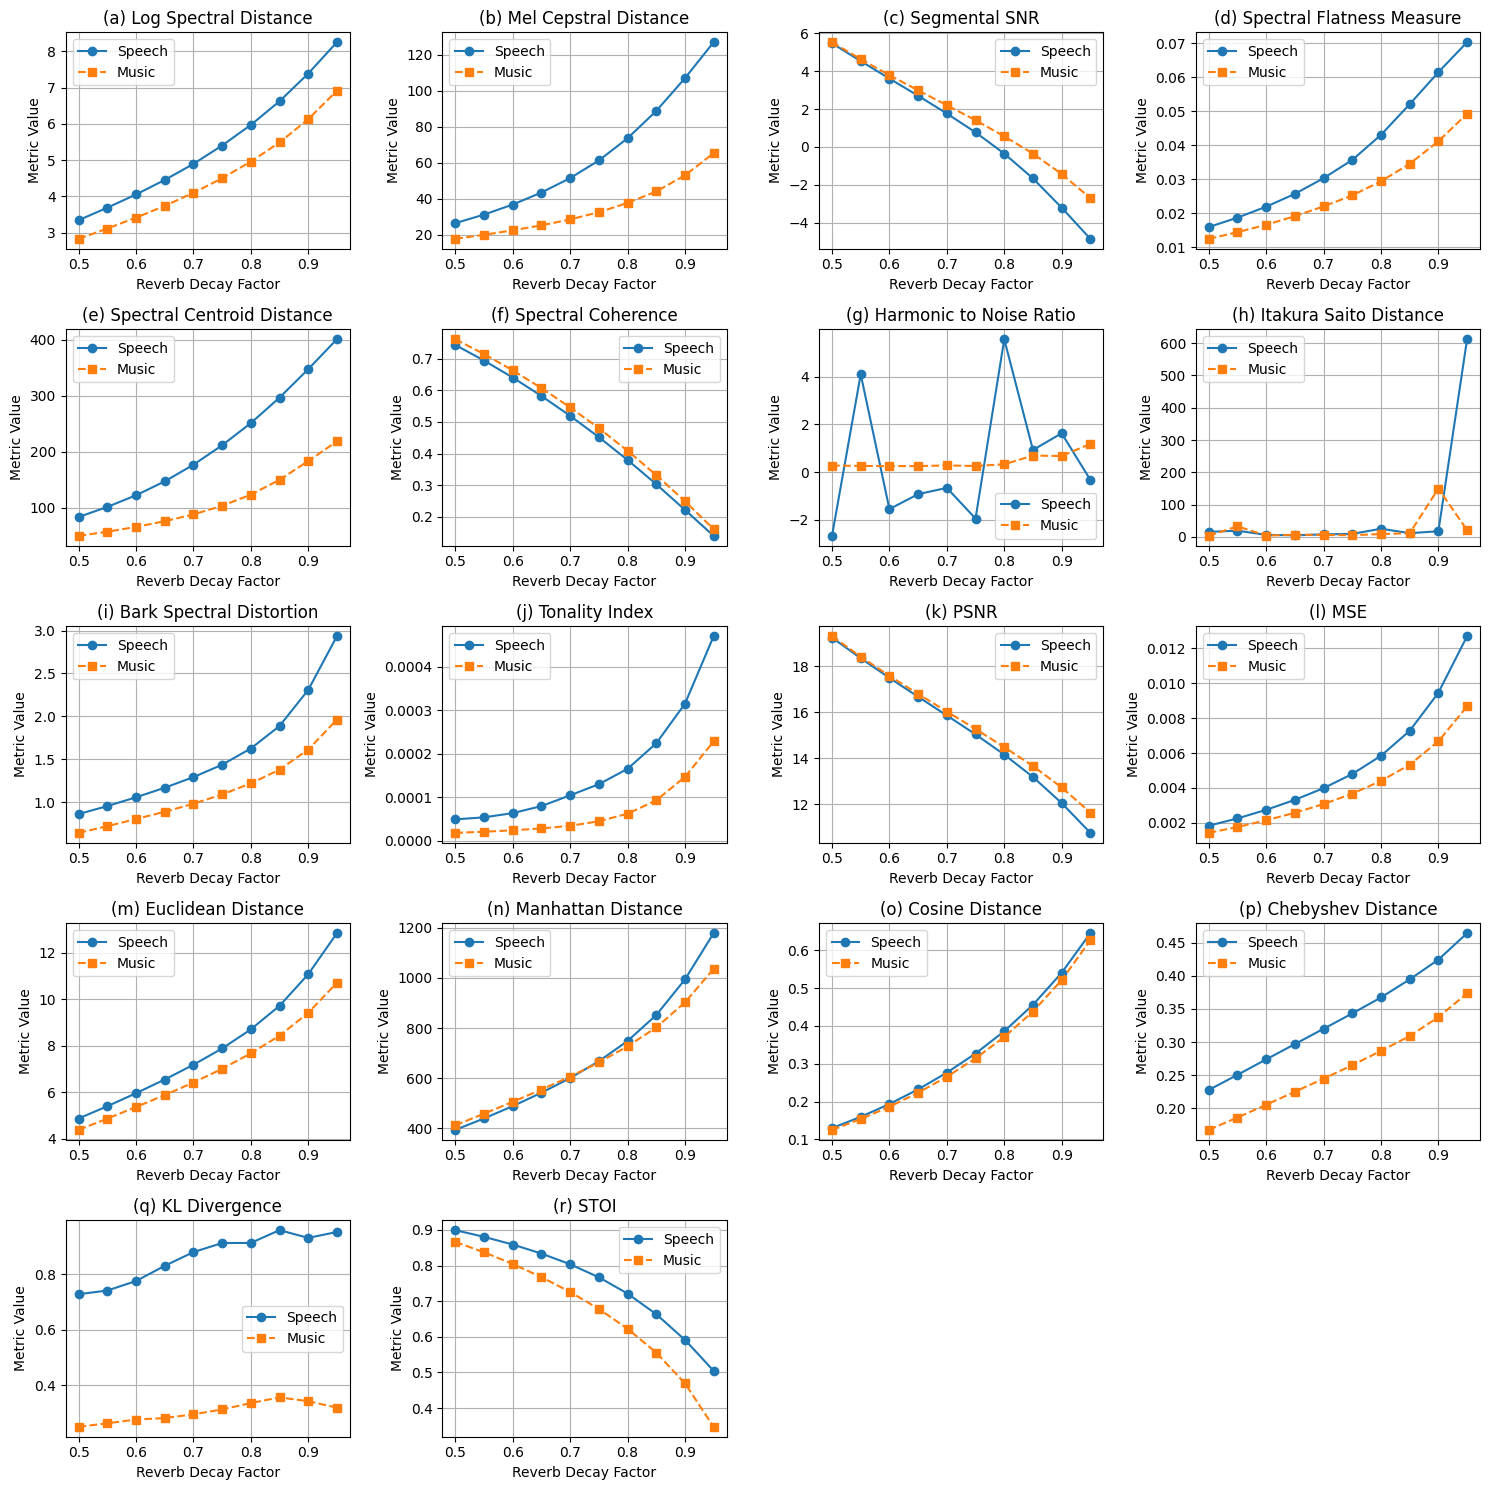

Analysis complete. Results saved to:
- reverb_quality_results.xlsx
- reverb_quality_metrics.png


In [ ]:
import numpy as np
import librosa
import time
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
import scipy.spatial
import scipy.stats
from scipy.linalg import norm
import pesq
from pystoi import stoi

class SignalMetrics:
    # [Keep the SignalMetrics class exactly as provided in original code]
    # ... (Same class implementation as original) ...
    def __init__(self, original, processed, sr=16000):
        """
        Initialize with original and processed signals.
        :param original: 1D numpy array of the original signal
        :param processed: 1D numpy array of the processed signal
        :param sr: Sampling rate of the signals (default 16 kHz)
        """
        self.original = original
        self.processed = processed
        self.sr = sr

    def log_spectral_distance(self):
        """Log Spectral Distance (LSD)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        lsd = np.mean((10 * np.log10(orig_spec / proc_spec)) ** 2)
        return np.sqrt(lsd)

    def mel_cepstral_distance(self):
        """Mel-Cepstral Distance (MCD)"""
        orig_mfcc = librosa.feature.mfcc(y=self.original, sr=self.sr)
        proc_mfcc = librosa.feature.mfcc(y=self.processed, sr=self.sr)
        return np.mean(np.linalg.norm(orig_mfcc - proc_mfcc, axis=0))

    def segmental_snr(self, frame_length=2048, overlap=1024):
        """Segmental Signal-to-Noise Ratio (SegSNR)"""
        orig_frames = librosa.util.frame(self.original, frame_length=frame_length, hop_length=overlap)
        proc_frames = librosa.util.frame(self.processed, frame_length=frame_length, hop_length=overlap)

        snr_list = []
        for o, p in zip(orig_frames.T, proc_frames.T):
            noise = o - p
            if np.any(o ** 2):
                snr_list.append(10 * np.log10(np.mean(o ** 2) / (np.mean(noise ** 2) + 1e-10)))

        return np.mean(snr_list) if snr_list else 0  # Avoid empty list issue

    def spectral_flatness_measure(self):
        """Spectral Flatness Measure (SFM)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        orig_sfm = scipy.stats.gmean(orig_spec, axis=0) / np.mean(orig_spec, axis=0)
        proc_sfm = scipy.stats.gmean(proc_spec, axis=0) / np.mean(proc_spec, axis=0)
        return np.mean(np.abs(orig_sfm - proc_sfm))

    def spectral_centroid_distance(self):
        """Spectral Centroid Distance"""
        orig_centroid = librosa.feature.spectral_centroid(y=self.original, sr=self.sr)
        proc_centroid = librosa.feature.spectral_centroid(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_centroid - proc_centroid))

    def spectral_coherence(self):
        """Spectral Coherence"""
        f, Cxy = scipy.signal.coherence(self.original, self.processed, fs=self.sr)
        return np.mean(Cxy)

    def harmonic_to_noise_ratio(self):
        """Harmonic-to-Noise Ratio (HNR)"""
        return librosa.effects.harmonic(self.processed).mean() / librosa.effects.percussive(self.processed).mean()

    def itakura_saito_distance(self):
        """Itakura-Saito Distance"""
        orig_psd = np.abs(librosa.stft(self.original)) ** 2
        proc_psd = np.abs(librosa.stft(self.processed)) ** 2
        return np.mean(orig_psd / proc_psd - np.log(orig_psd / proc_psd) - 1)

    def bark_spectral_distortion(self):
        """Bark Spectral Distortion (Approximated using Mel-frequency)"""
        orig_mel = librosa.feature.melspectrogram(y=self.original, sr=self.sr)
        proc_mel = librosa.feature.melspectrogram(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_mel - proc_mel))

    def tonality_index(self):
        """Tonality Index (Ratio of Harmonic Energy to Total Energy)"""
        orig_harmonic = librosa.effects.harmonic(self.original)
        proc_harmonic = librosa.effects.harmonic(self.processed)
        return np.abs(np.mean(orig_harmonic) - np.mean(proc_harmonic))

    def psnr(self):
        """Peak Signal-to-Noise Ratio (PSNR)"""
        mse_val = self.mse()
        max_val = np.max(self.original) ** 2
        return 10 * np.log10(max_val / (mse_val + 1e-10))

    def mse(self):
        """Mean Squared Error (MSE)"""
        return np.mean((self.original - self.processed) ** 2)

    def euclidean_distance(self):
        """Euclidean Distance"""
        return np.linalg.norm(self.original - self.processed)

    def manhattan_distance(self):
        """Manhattan Distance"""
        return np.sum(np.abs(self.original - self.processed))

    def cosine_distance(self):
        """Cosine Distance"""
        return scipy.spatial.distance.cosine(self.original, self.processed)

    def chebyshev_distance(self):
        """Chebyshev Distance"""
        return np.max(np.abs(self.original - self.processed))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def kl_divergence(self):
        """Kullback-Leibler (KL) Divergence"""
        orig_hist = np.histogram(self.original, bins=256, density=True)[0] + 1e-10
        proc_hist = np.histogram(self.processed, bins=256, density=True)[0] + 1e-10
        return scipy.stats.entropy(orig_hist, proc_hist)

    def pesq(self):
        """Perceptual Evaluation of Speech Quality (PESQ)"""
        # PESQ requires signals to be resampled to 16 kHz or 8 kHz
        if self.sr not in [8000, 16000]:
            raise ValueError("PESQ requires sampling rate of 8000 Hz or 16000 Hz.")
        return pesq.pesq(self.sr, self.original, self.processed, 'wb')  # 'wb' for wideband

    def stoi(self):
        """Short-Time Objective Intelligibility (STOI)"""
        return stoi(self.original, self.processed, self.sr, extended=False)

    def compute_all_metrics(self):
        """Compute all metrics"""
        return {
            'Log Spectral Distance': self.log_spectral_distance(),
            'Mel Cepstral Distance': self.mel_cepstral_distance(),
            'Segmental SNR': self.segmental_snr(),
            'Spectral Flatness Measure': self.spectral_flatness_measure(),
            'Spectral Centroid Distance': self.spectral_centroid_distance(),
            'Spectral Coherence': self.spectral_coherence(),
            'Harmonic to Noise Ratio': self.harmonic_to_noise_ratio(),
            'Itakura Saito Distance': self.itakura_saito_distance(),
            'Bark Spectral Distortion': self.bark_spectral_distortion(),
            'Tonality Index': self.tonality_index(),
            'PSNR': self.psnr(),
            'MSE': self.mse(),
            'Euclidean Distance': self.euclidean_distance(),
            'Manhattan Distance': self.manhattan_distance(),
            'Cosine Distance': self.cosine_distance(),
            'Chebyshev Distance': self.chebyshev_distance(),
            #'Shannon Entropy': self.shannon_entropy(self.processed),
            'KL Divergence': self.kl_divergence(),
            #'PESQ': self.pesq(),
            'STOI': self.stoi()
        }



#import librosa

def apply_reverb(signal, decay, sr=16000, delay_time=0.02, max_reverb_time=0.5):
    """Applies reverberation using exponentially decaying reflections."""
    delay_samples = int(delay_time * sr)
    max_reverb_samples = int(max_reverb_time * sr)
    rir_length = min(max_reverb_samples, len(signal))
    rir = np.zeros(rir_length)
    rir[0] = 1.0  # Direct path

    current_delay = delay_samples
    current_gain = decay

    # Add reflections with exponential decay
    while current_delay < rir_length and current_gain > 0.001:
        rir[current_delay] += current_gain
        current_delay += delay_samples
        current_gain *= decay

    # Convolve signal with RIR and truncate to original length
    processed = scipy.signal.convolve(signal, rir, mode='full')[:len(signal)]

    # Normalize to prevent clipping
    processed = processed / np.max(np.abs(processed)) * np.max(np.abs(signal))
    return processed

# Load and prepare datasets (same as original)
speech1, sr = librosa.load(librosa.example('libri1'), sr=16000)
speech2, _ = librosa.load(librosa.example('libri2'), sr=16000)
speech3, _ = librosa.load(librosa.example('libri3'), sr=16000)
music1, _ = librosa.load(librosa.example('brahms'), sr=16000)
music2, _ = librosa.load(librosa.example('nutcracker'), sr=16000)

speech = np.concatenate([speech1, speech2, speech3])
music = np.concatenate([music1, music2])

# Verify duration
if len(speech)/sr < 45 or len(music)/sr < 45:
    raise ValueError("Insufficient data duration")

# Create 1-second segments
speech_segments = [speech[i*sr:(i+1)*sr] for i in range(45)]
music_segments = [music[i*sr:(i+1)*sr] for i in range(45)]

# Define reverb decay parameters
reverb_decays = np.linspace(0.5, 0.95, 10)  # Controls reverb intensity

# Initialize results storage
metric_names = list(SignalMetrics(speech_segments[0], speech_segments[0]).compute_all_metrics().keys())
speech_results = {metric: [] for metric in metric_names}
music_results = {metric: [] for metric in metric_names}
time_consumption = {metric: [] for metric in metric_names}

# Main processing loop
for decay in reverb_decays:
    speech_avg = {m: 0 for m in metric_names}
    music_avg = {m: 0 for m in metric_names}
    time_avg = {m: 0 for m in metric_names}

    for orig_speech, orig_music in zip(speech_segments, music_segments):
        # Apply reverberation
        rev_speech = apply_reverb(orig_speech, decay, sr)
        rev_music = apply_reverb(orig_music, decay, sr)

        # Compute metrics
        speech_metrics = SignalMetrics(orig_speech, rev_speech, sr)
        music_metrics = SignalMetrics(orig_music, rev_music, sr)

        for metric in metric_names:
            start = time.time()
            try:
                s_val = getattr(speech_metrics, metric.lower().replace(" ", "_"))()
                m_val = getattr(music_metrics, metric.lower().replace(" ", "_"))()
            except:
                s_val, m_val = np.nan, np.nan

            elapsed = time.time() - start

            speech_avg[metric] += s_val / 45
            music_avg[metric] += m_val / 45
            time_avg[metric] += elapsed / 45

    # Store results
    for metric in metric_names:
        speech_results[metric].append(speech_avg[metric])
        music_results[metric].append(music_avg[metric])
        time_consumption[metric].append(time_avg[metric])

# Plotting (updated labels)
num_metrics = len(metric_names)
rows = (num_metrics // 4) + (1 if num_metrics % 4 else 0)
fig, axes = plt.subplots(rows, 4, figsize=(15, rows*3))
axes = axes.flatten()

for i, metric in enumerate(metric_names):
    ax = axes[i]
    ax.plot(reverb_decays, speech_results[metric], 'o-', label='Speech')
    ax.plot(reverb_decays, music_results[metric], 's--', label='Music')
    ax.set_title(f"({chr(97+i)}) {metric}")
    ax.set_xlabel("Reverb Decay Factor")
    ax.set_ylabel("Metric Value")
    ax.legend()
    ax.grid(True)

# Clean up empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("reverb_quality_metrics.png")
plt.show()

# Export to Excel (updated indices)
df_speech = pd.DataFrame(speech_results, index=reverb_decays)
df_music = pd.DataFrame(music_results, index=reverb_decays)
df_time = pd.DataFrame(time_consumption, index=reverb_decays)

with pd.ExcelWriter("reverb_quality_results.xlsx") as writer:
    df_speech.to_excel(writer, sheet_name="Speech Metrics")
    df_music.to_excel(writer, sheet_name="Music Metrics")
    df_time.to_excel(writer, sheet_name="Time Consumption")

print("Analysis complete. Results saved to:")
print("- reverb_quality_results.xlsx")
print("- reverb_quality_metrics.png")

# **Metrics sensitivity to Clipping Ratio**

/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure

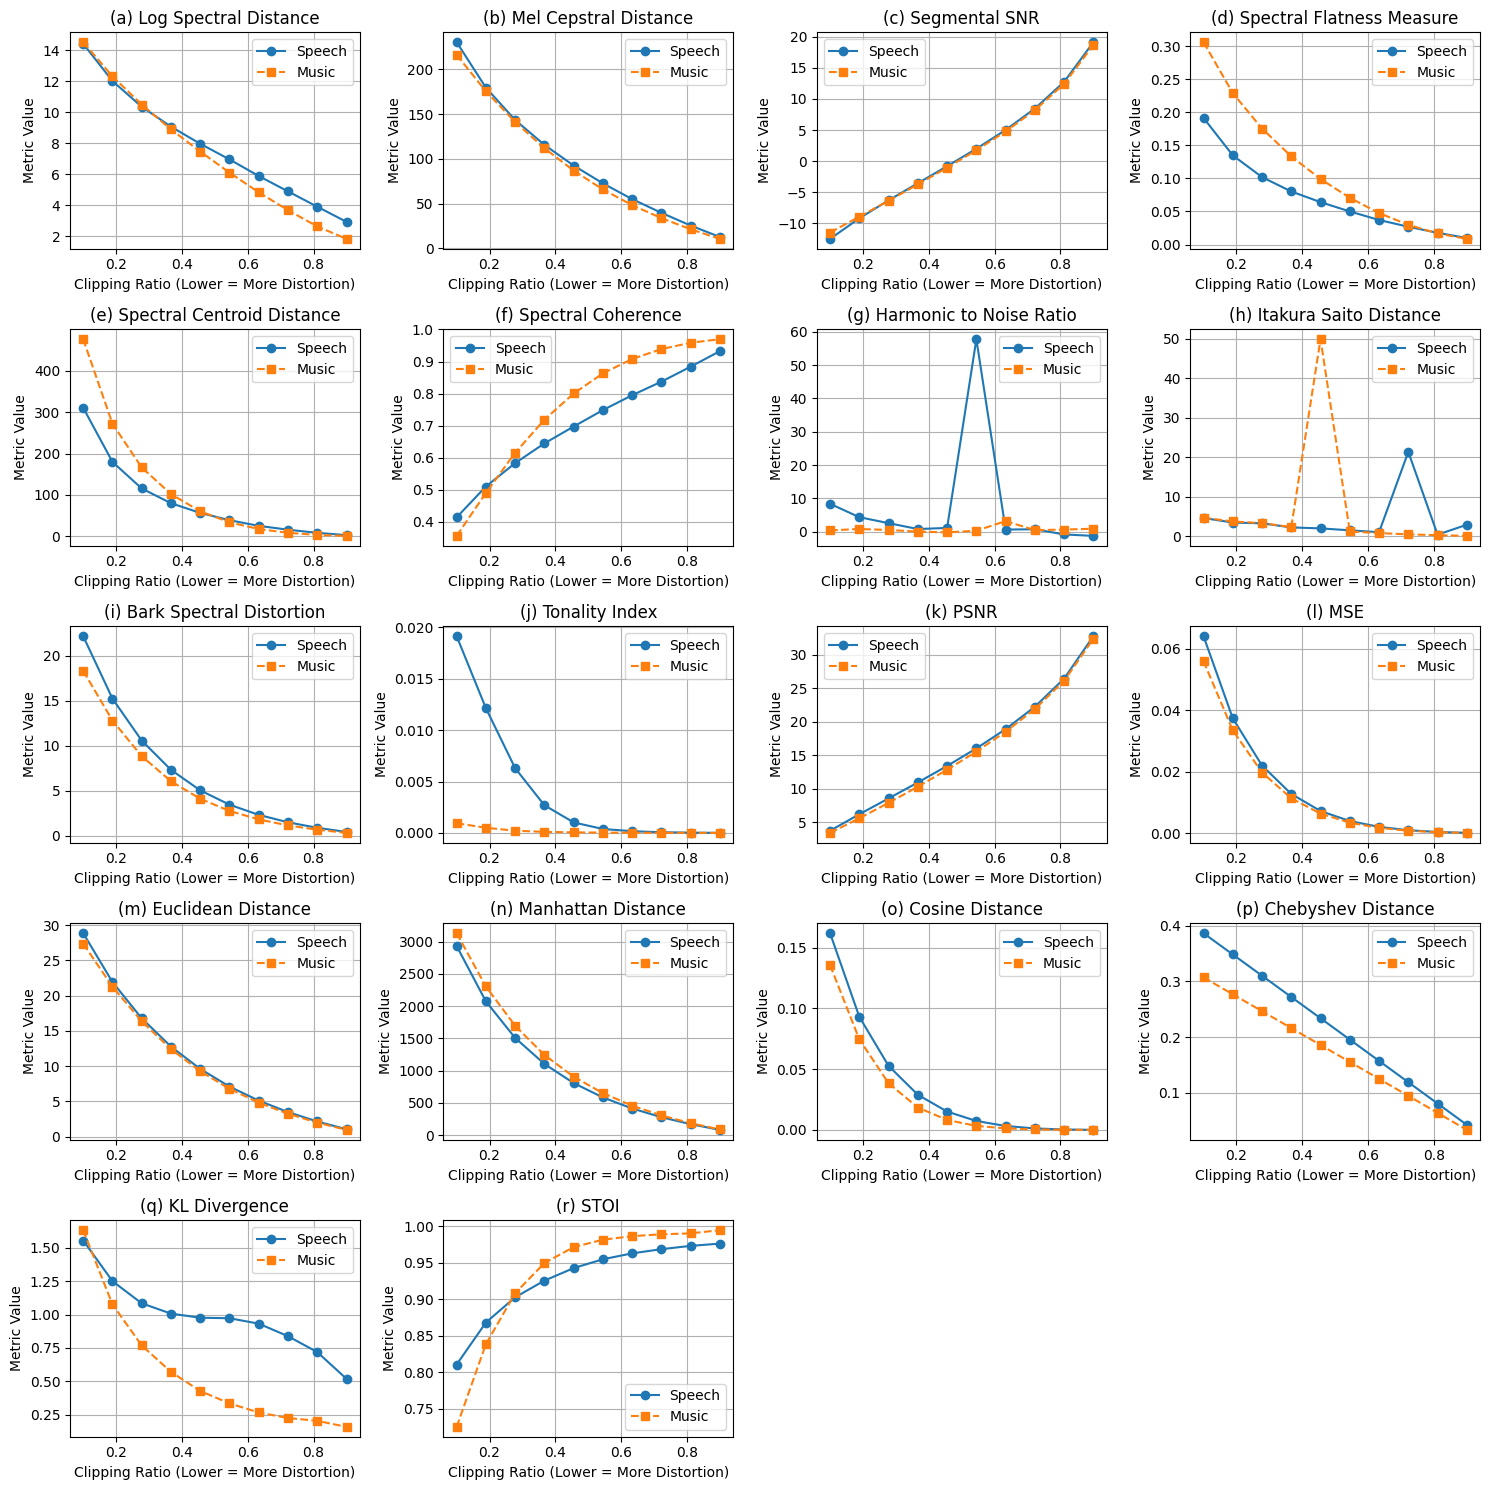

Clipping analysis complete. Results saved to:
- clipping_quality_results.xlsx
- clipping_quality_metrics.png


In [ ]:
import numpy as np
import librosa
import time
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
import scipy.spatial
import scipy.stats
from scipy.linalg import norm
import pesq
from pystoi import stoi

# [Keep the SignalMetrics class exactly as provided in original code]
# ... (Same class implementation as original) ...

class SignalMetrics:
    # [Keep the SignalMetrics class exactly as provided in original code]
    # ... (Same class implementation as original) ...
    def __init__(self, original, processed, sr=16000):
        """
        Initialize with original and processed signals.
        :param original: 1D numpy array of the original signal
        :param processed: 1D numpy array of the processed signal
        :param sr: Sampling rate of the signals (default 16 kHz)
        """
        self.original = original
        self.processed = processed
        self.sr = sr

    def log_spectral_distance(self):
        """Log Spectral Distance (LSD)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        lsd = np.mean((10 * np.log10(orig_spec / proc_spec)) ** 2)
        return np.sqrt(lsd)

    def mel_cepstral_distance(self):
        """Mel-Cepstral Distance (MCD)"""
        orig_mfcc = librosa.feature.mfcc(y=self.original, sr=self.sr)
        proc_mfcc = librosa.feature.mfcc(y=self.processed, sr=self.sr)
        return np.mean(np.linalg.norm(orig_mfcc - proc_mfcc, axis=0))

    def segmental_snr(self, frame_length=2048, overlap=1024):
        """Segmental Signal-to-Noise Ratio (SegSNR)"""
        orig_frames = librosa.util.frame(self.original, frame_length=frame_length, hop_length=overlap)
        proc_frames = librosa.util.frame(self.processed, frame_length=frame_length, hop_length=overlap)

        snr_list = []
        for o, p in zip(orig_frames.T, proc_frames.T):
            noise = o - p
            if np.any(o ** 2):
                snr_list.append(10 * np.log10(np.mean(o ** 2) / (np.mean(noise ** 2) + 1e-10)))

        return np.mean(snr_list) if snr_list else 0  # Avoid empty list issue

    def spectral_flatness_measure(self):
        """Spectral Flatness Measure (SFM)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        orig_sfm = scipy.stats.gmean(orig_spec, axis=0) / np.mean(orig_spec, axis=0)
        proc_sfm = scipy.stats.gmean(proc_spec, axis=0) / np.mean(proc_spec, axis=0)
        return np.mean(np.abs(orig_sfm - proc_sfm))

    def spectral_centroid_distance(self):
        """Spectral Centroid Distance"""
        orig_centroid = librosa.feature.spectral_centroid(y=self.original, sr=self.sr)
        proc_centroid = librosa.feature.spectral_centroid(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_centroid - proc_centroid))

    def spectral_coherence(self):
        """Spectral Coherence"""
        f, Cxy = scipy.signal.coherence(self.original, self.processed, fs=self.sr)
        return np.mean(Cxy)

    def harmonic_to_noise_ratio(self):
        """Harmonic-to-Noise Ratio (HNR)"""
        return librosa.effects.harmonic(self.processed).mean() / librosa.effects.percussive(self.processed).mean()

    def itakura_saito_distance(self):
        """Itakura-Saito Distance"""
        orig_psd = np.abs(librosa.stft(self.original)) ** 2
        proc_psd = np.abs(librosa.stft(self.processed)) ** 2
        return np.mean(orig_psd / proc_psd - np.log(orig_psd / proc_psd) - 1)

    def bark_spectral_distortion(self):
        """Bark Spectral Distortion (Approximated using Mel-frequency)"""
        orig_mel = librosa.feature.melspectrogram(y=self.original, sr=self.sr)
        proc_mel = librosa.feature.melspectrogram(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_mel - proc_mel))

    def tonality_index(self):
        """Tonality Index (Ratio of Harmonic Energy to Total Energy)"""
        orig_harmonic = librosa.effects.harmonic(self.original)
        proc_harmonic = librosa.effects.harmonic(self.processed)
        return np.abs(np.mean(orig_harmonic) - np.mean(proc_harmonic))

    def psnr(self):
        """Peak Signal-to-Noise Ratio (PSNR)"""
        mse_val = self.mse()
        max_val = np.max(self.original) ** 2
        return 10 * np.log10(max_val / (mse_val + 1e-10))

    def mse(self):
        """Mean Squared Error (MSE)"""
        return np.mean((self.original - self.processed) ** 2)

    def euclidean_distance(self):
        """Euclidean Distance"""
        return np.linalg.norm(self.original - self.processed)

    def manhattan_distance(self):
        """Manhattan Distance"""
        return np.sum(np.abs(self.original - self.processed))

    def cosine_distance(self):
        """Cosine Distance"""
        return scipy.spatial.distance.cosine(self.original, self.processed)

    def chebyshev_distance(self):
        """Chebyshev Distance"""
        return np.max(np.abs(self.original - self.processed))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def kl_divergence(self):
        """Kullback-Leibler (KL) Divergence"""
        orig_hist = np.histogram(self.original, bins=256, density=True)[0] + 1e-10
        proc_hist = np.histogram(self.processed, bins=256, density=True)[0] + 1e-10
        return scipy.stats.entropy(orig_hist, proc_hist)

    def pesq(self):
        """Perceptual Evaluation of Speech Quality (PESQ)"""
        # PESQ requires signals to be resampled to 16 kHz or 8 kHz
        if self.sr not in [8000, 16000]:
            raise ValueError("PESQ requires sampling rate of 8000 Hz or 16000 Hz.")
        return pesq.pesq(self.sr, self.original, self.processed, 'wb')  # 'wb' for wideband

    def stoi(self):
        """Short-Time Objective Intelligibility (STOI)"""
        return stoi(self.original, self.processed, self.sr, extended=False)

    def compute_all_metrics(self):
        """Compute all metrics"""
        return {
            'Log Spectral Distance': self.log_spectral_distance(),
            'Mel Cepstral Distance': self.mel_cepstral_distance(),
            'Segmental SNR': self.segmental_snr(),
            'Spectral Flatness Measure': self.spectral_flatness_measure(),
            'Spectral Centroid Distance': self.spectral_centroid_distance(),
            'Spectral Coherence': self.spectral_coherence(),
            'Harmonic to Noise Ratio': self.harmonic_to_noise_ratio(),
            'Itakura Saito Distance': self.itakura_saito_distance(),
            'Bark Spectral Distortion': self.bark_spectral_distortion(),
            'Tonality Index': self.tonality_index(),
            'PSNR': self.psnr(),
            'MSE': self.mse(),
            'Euclidean Distance': self.euclidean_distance(),
            'Manhattan Distance': self.manhattan_distance(),
            'Cosine Distance': self.cosine_distance(),
            'Chebyshev Distance': self.chebyshev_distance(),
            #'Shannon Entropy': self.shannon_entropy(self.processed),
            'KL Divergence': self.kl_divergence(),
            #'PESQ': self.pesq(),
            'STOI': self.stoi()
        }



#import librosa




def apply_clipping(signal, clip_ratio):
    """
    Apply nonlinear distortion through symmetric clipping
    :param clip_ratio: Ratio of maximum amplitude to clip (0.1-0.9)
                       Lower values = more severe distortion
    """
    max_amp = np.max(np.abs(signal))
    threshold = clip_ratio * max_amp
    distorted = np.clip(signal, -threshold, threshold)

    # Normalize to original peak amplitude to maintain loudness
    return distorted * (max_amp / (threshold + 1e-10))

# Load and prepare datasets (same as original)
speech1, sr = librosa.load(librosa.example('libri1'), sr=16000)
speech2, _ = librosa.load(librosa.example('libri2'), sr=16000)
speech3, _ = librosa.load(librosa.example('libri3'), sr=16000)
music1, _ = librosa.load(librosa.example('brahms'), sr=16000)
music2, _ = librosa.load(librosa.example('nutcracker'), sr=16000)

speech = np.concatenate([speech1, speech2, speech3])
music = np.concatenate([music1, music2])

# Create 1-second segments
speech_segments = [speech[i*sr:(i+1)*sr] for i in range(45)]
music_segments = [music[i*sr:(i+1)*sr] for i in range(45)]

# Define clipping parameters
clip_ratios = np.linspace(0.1, 0.9, 10)  # More clipping at lower values

# Initialize results storage
metric_names = list(SignalMetrics(speech_segments[0], speech_segments[0]).compute_all_metrics().keys())
speech_results = {metric: [] for metric in metric_names}
music_results = {metric: [] for metric in metric_names}
time_consumption = {metric: [] for metric in metric_names}

# Main processing loop
for ratio in clip_ratios:
    speech_avg = {m: 0 for m in metric_names}
    music_avg = {m: 0 for m in metric_names}
    time_avg = {m: 0 for m in metric_names}

    for orig_speech, orig_music in zip(speech_segments, music_segments):
        # Apply clipping distortion
        distorted_speech = apply_clipping(orig_speech, ratio)
        distorted_music = apply_clipping(orig_music, ratio)

        # Compute metrics
        speech_metrics = SignalMetrics(orig_speech, distorted_speech, sr)
        music_metrics = SignalMetrics(orig_music, distorted_music, sr)

        for metric in metric_names:
            start = time.time()
            try:
                s_val = getattr(speech_metrics, metric.lower().replace(" ", "_"))()
                m_val = getattr(music_metrics, metric.lower().replace(" ", "_"))()
            except:
                s_val, m_val = np.nan, np.nan

            elapsed = time.time() - start

            speech_avg[metric] += s_val / 45
            music_avg[metric] += m_val / 45
            time_avg[metric] += elapsed / 45

    # Store results
    for metric in metric_names:
        speech_results[metric].append(speech_avg[metric])
        music_results[metric].append(music_avg[metric])
        time_consumption[metric].append(time_avg[metric])

# Plotting (updated labels)
num_metrics = len(metric_names)
rows = (num_metrics // 4) + (1 if num_metrics % 4 else 0)
fig, axes = plt.subplots(rows, 4, figsize=(15, rows*3))
axes = axes.flatten()

for i, metric in enumerate(metric_names):
    ax = axes[i]
    ax.plot(clip_ratios, speech_results[metric], 'o-', label='Speech')
    ax.plot(clip_ratios, music_results[metric], 's--', label='Music')
    ax.set_title(f"({chr(97+i)}) {metric}")
    ax.set_xlabel("Clipping Ratio (Lower = More Distortion)")
    ax.set_ylabel("Metric Value")
    ax.legend()
    ax.grid(True)

# Clean up empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("clipping_quality_metrics.png")
plt.show()

# Export to Excel
df_speech = pd.DataFrame(speech_results, index=clip_ratios)
df_music = pd.DataFrame(music_results, index=clip_ratios)
df_time = pd.DataFrame(time_consumption, index=clip_ratios)

with pd.ExcelWriter("clipping_quality_results.xlsx") as writer:
    df_speech.to_excel(writer, sheet_name="Speech Metrics")
    df_music.to_excel(writer, sheet_name="Music Metrics")
    df_time.to_excel(writer, sheet_name="Time Consumption")

print("Clipping analysis complete. Results saved to:")
print("- clipping_quality_results.xlsx")
print("- clipping_quality_metrics.png")

# **Metrics sensitivity to Bit depth**

/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '
<ipython-input-53-d2e1c82c9f45>:81: RuntimeWarning: divide by zero encountered in divide
  return np.mean(orig_psd / proc_psd - np.log(orig_psd / proc_psd) - 1)
<ipython-input-53-d2e1c82c9f45>:81: RuntimeWarning: invalid value encountered in subtract
  return np.mean(orig_psd / proc_psd - np.log(orig_psd / proc_psd) - 1)
/usr/local/lib/python3.11/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to comput

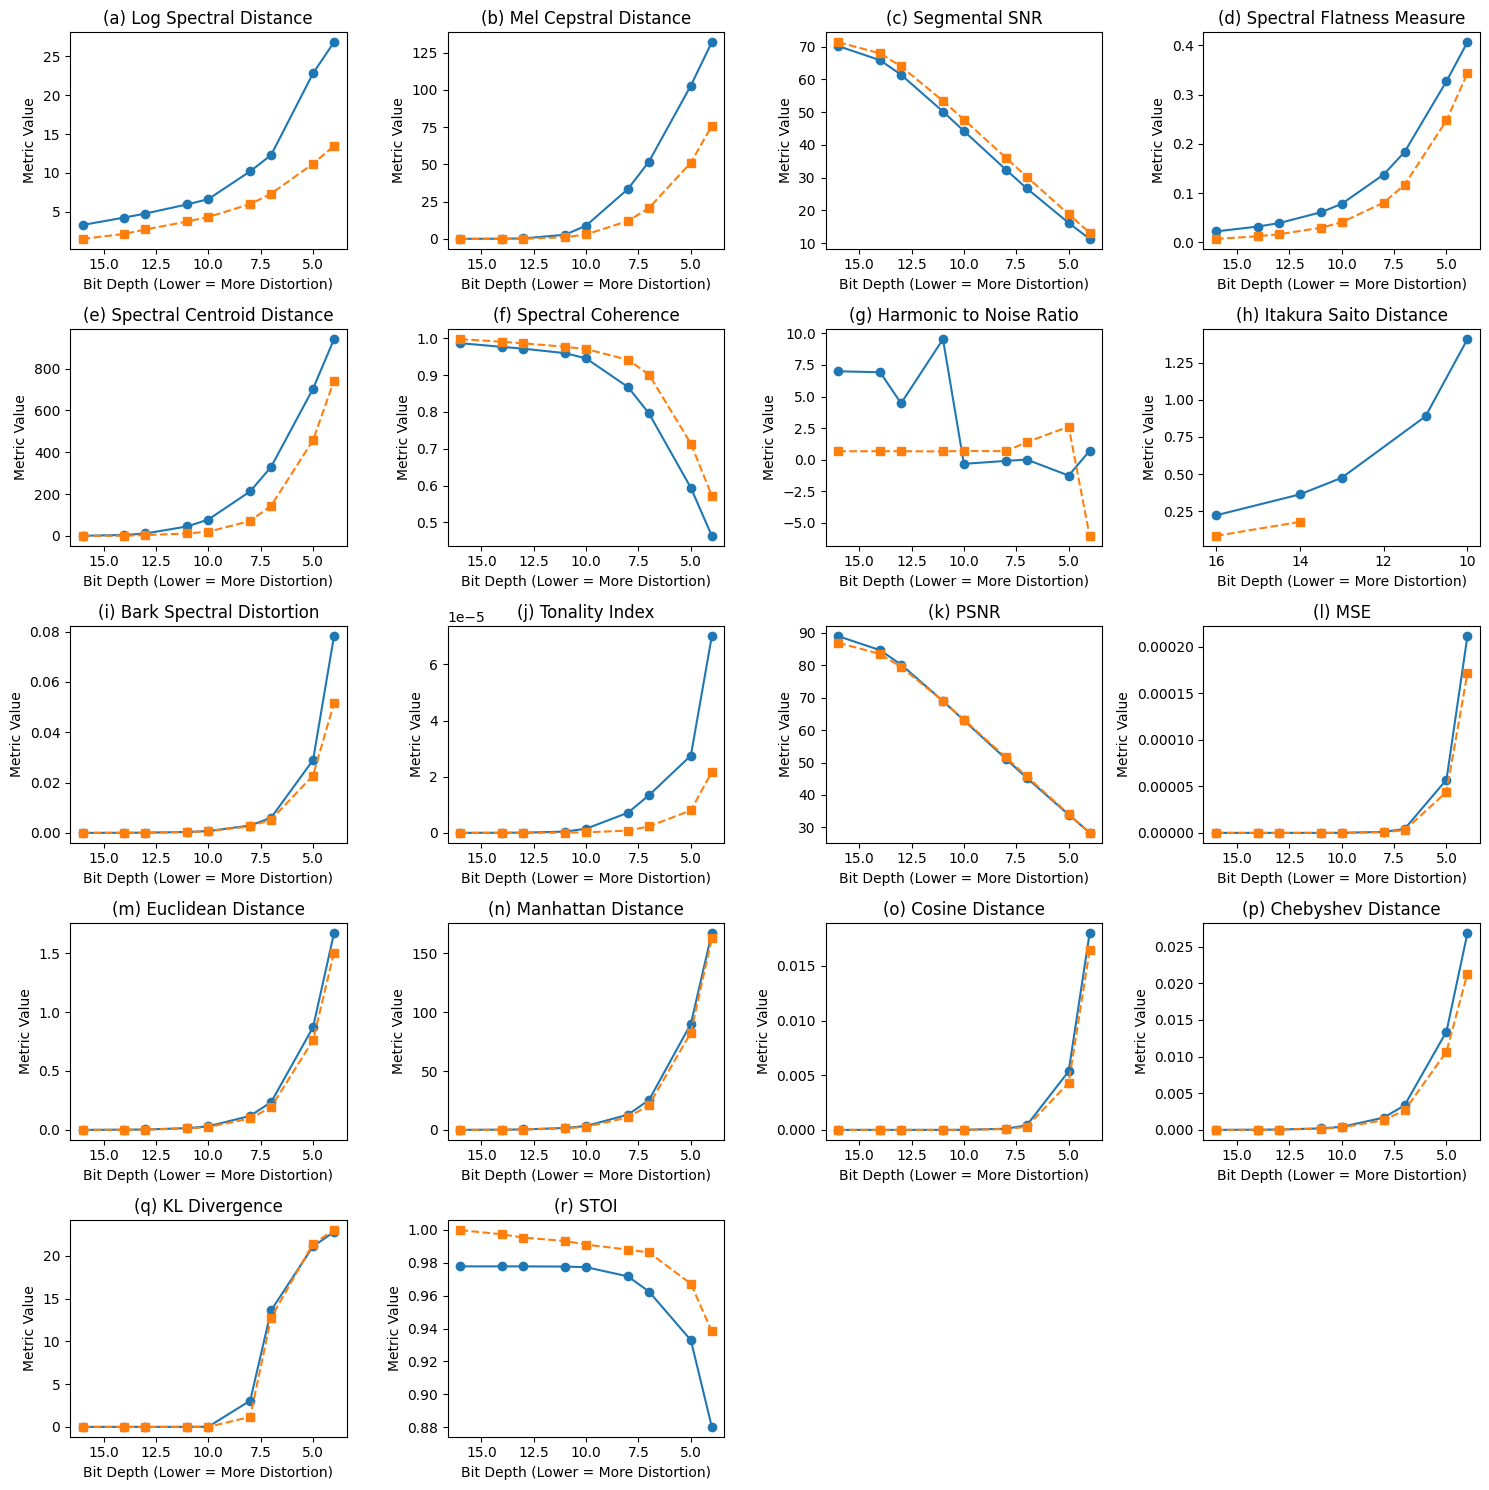

Bitcrush analysis complete. Results saved to:
- bitcrush_quality_results.xlsx
- bitcrush_quality_metrics.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import librosa
import time
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
import scipy.spatial
import scipy.stats
from scipy.linalg import norm
import pesq
from pystoi import stoi

# [Keep the SignalMetrics class unchanged from original code]
class SignalMetrics:
    # [Keep the SignalMetrics class exactly as provided in original code]
    # ... (Same class implementation as original) ...
    def __init__(self, original, processed, sr=16000):
        """
        Initialize with original and processed signals.
        :param original: 1D numpy array of the original signal
        :param processed: 1D numpy array of the processed signal
        :param sr: Sampling rate of the signals (default 16 kHz)
        """
        self.original = original
        self.processed = processed
        self.sr = sr

    def log_spectral_distance(self):
        """Log Spectral Distance (LSD)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        lsd = np.mean((10 * np.log10(orig_spec / proc_spec)) ** 2)
        return np.sqrt(lsd)

    def mel_cepstral_distance(self):
        """Mel-Cepstral Distance (MCD)"""
        orig_mfcc = librosa.feature.mfcc(y=self.original, sr=self.sr)
        proc_mfcc = librosa.feature.mfcc(y=self.processed, sr=self.sr)
        return np.mean(np.linalg.norm(orig_mfcc - proc_mfcc, axis=0))

    def segmental_snr(self, frame_length=2048, overlap=1024):
        """Segmental Signal-to-Noise Ratio (SegSNR)"""
        orig_frames = librosa.util.frame(self.original, frame_length=frame_length, hop_length=overlap)
        proc_frames = librosa.util.frame(self.processed, frame_length=frame_length, hop_length=overlap)

        snr_list = []
        for o, p in zip(orig_frames.T, proc_frames.T):
            noise = o - p
            if np.any(o ** 2):
                snr_list.append(10 * np.log10(np.mean(o ** 2) / (np.mean(noise ** 2) + 1e-10)))

        return np.mean(snr_list) if snr_list else 0  # Avoid empty list issue

    def spectral_flatness_measure(self):
        """Spectral Flatness Measure (SFM)"""
        orig_spec = np.abs(librosa.stft(self.original)) + 1e-10
        proc_spec = np.abs(librosa.stft(self.processed)) + 1e-10
        orig_sfm = scipy.stats.gmean(orig_spec, axis=0) / np.mean(orig_spec, axis=0)
        proc_sfm = scipy.stats.gmean(proc_spec, axis=0) / np.mean(proc_spec, axis=0)
        return np.mean(np.abs(orig_sfm - proc_sfm))

    def spectral_centroid_distance(self):
        """Spectral Centroid Distance"""
        orig_centroid = librosa.feature.spectral_centroid(y=self.original, sr=self.sr)
        proc_centroid = librosa.feature.spectral_centroid(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_centroid - proc_centroid))

    def spectral_coherence(self):
        """Spectral Coherence"""
        f, Cxy = scipy.signal.coherence(self.original, self.processed, fs=self.sr)
        return np.mean(Cxy)

    def harmonic_to_noise_ratio(self):
        """Harmonic-to-Noise Ratio (HNR)"""
        return librosa.effects.harmonic(self.processed).mean() / librosa.effects.percussive(self.processed).mean()

    def itakura_saito_distance(self):
        """Itakura-Saito Distance"""
        orig_psd = np.abs(librosa.stft(self.original)) ** 2
        proc_psd = np.abs(librosa.stft(self.processed)) ** 2
        return np.mean(orig_psd / proc_psd - np.log(orig_psd / proc_psd) - 1)

    def bark_spectral_distortion(self):
        """Bark Spectral Distortion (Approximated using Mel-frequency)"""
        orig_mel = librosa.feature.melspectrogram(y=self.original, sr=self.sr)
        proc_mel = librosa.feature.melspectrogram(y=self.processed, sr=self.sr)
        return np.mean(np.abs(orig_mel - proc_mel))

    def tonality_index(self):
        """Tonality Index (Ratio of Harmonic Energy to Total Energy)"""
        orig_harmonic = librosa.effects.harmonic(self.original)
        proc_harmonic = librosa.effects.harmonic(self.processed)
        return np.abs(np.mean(orig_harmonic) - np.mean(proc_harmonic))

    def psnr(self):
        """Peak Signal-to-Noise Ratio (PSNR)"""
        mse_val = self.mse()
        max_val = np.max(self.original) ** 2
        return 10 * np.log10(max_val / (mse_val + 1e-10))

    def mse(self):
        """Mean Squared Error (MSE)"""
        return np.mean((self.original - self.processed) ** 2)

    def euclidean_distance(self):
        """Euclidean Distance"""
        return np.linalg.norm(self.original - self.processed)

    def manhattan_distance(self):
        """Manhattan Distance"""
        return np.sum(np.abs(self.original - self.processed))

    def cosine_distance(self):
        """Cosine Distance"""
        return scipy.spatial.distance.cosine(self.original, self.processed)

    def chebyshev_distance(self):
        """Chebyshev Distance"""
        return np.max(np.abs(self.original - self.processed))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def shannon_entropy(self, signal):
        """Shannon Entropy"""
        prob_dist = np.histogram(signal, bins=256, density=True)[0]
        prob_dist = prob_dist[prob_dist > 0]
        return -np.sum(prob_dist * np.log2(prob_dist))

    def kl_divergence(self):
        """Kullback-Leibler (KL) Divergence"""
        orig_hist = np.histogram(self.original, bins=256, density=True)[0] + 1e-10
        proc_hist = np.histogram(self.processed, bins=256, density=True)[0] + 1e-10
        return scipy.stats.entropy(orig_hist, proc_hist)

    def pesq(self):
        """Perceptual Evaluation of Speech Quality (PESQ)"""
        # PESQ requires signals to be resampled to 16 kHz or 8 kHz
        if self.sr not in [8000, 16000]:
            raise ValueError("PESQ requires sampling rate of 8000 Hz or 16000 Hz.")
        return pesq.pesq(self.sr, self.original, self.processed, 'wb')  # 'wb' for wideband

    def stoi(self):
        """Short-Time Objective Intelligibility (STOI)"""
        return stoi(self.original, self.processed, self.sr, extended=False)

    def compute_all_metrics(self):
        """Compute all metrics"""
        return {
            'Log Spectral Distance': self.log_spectral_distance(),
            'Mel Cepstral Distance': self.mel_cepstral_distance(),
            'Segmental SNR': self.segmental_snr(),
            'Spectral Flatness Measure': self.spectral_flatness_measure(),
            'Spectral Centroid Distance': self.spectral_centroid_distance(),
            'Spectral Coherence': self.spectral_coherence(),
            'Harmonic to Noise Ratio': self.harmonic_to_noise_ratio(),
            'Itakura Saito Distance': self.itakura_saito_distance(),
            'Bark Spectral Distortion': self.bark_spectral_distortion(),
            'Tonality Index': self.tonality_index(),
            'PSNR': self.psnr(),
            'MSE': self.mse(),
            'Euclidean Distance': self.euclidean_distance(),
            'Manhattan Distance': self.manhattan_distance(),
            'Cosine Distance': self.cosine_distance(),
            'Chebyshev Distance': self.chebyshev_distance(),
            #'Shannon Entropy': self.shannon_entropy(self.processed),
            'KL Divergence': self.kl_divergence(),
            #'PESQ': self.pesq(),
            'STOI': self.stoi()
        }



def apply_bitcrush(signal, bit_depth):
    """
    Apply bit-depth reduction quantization distortion
    :param bit_depth: Target bit depth (1-16 bits)
    """
    # Scale signal to [-1, 1] range
    max_val = np.max(np.abs(signal))
    scaled = signal / max_val

    # Quantization process
    quantized = np.round(scaled * (2**(bit_depth-1))) / (2**(bit_depth-1))

    # Scale back to original range
    return quantized * max_val

# Load and prepare datasets (same as original)
# Load and prepare datasets (same as original)
speech1, sr = librosa.load(librosa.example('libri1'), sr=16000)
speech2, _ = librosa.load(librosa.example('libri2'), sr=16000)
speech3, _ = librosa.load(librosa.example('libri3'), sr=16000)
music1, _ = librosa.load(librosa.example('brahms'), sr=16000)
music2, _ = librosa.load(librosa.example('nutcracker'), sr=16000)

# Define bit-depth parameters
bit_depths = np.arange(16, 3, -1.5).astype(int)  # From 16 bits to 4 bits

# Initialize results storage
metric_names = list(SignalMetrics(speech_segments[0], speech_segments[0]).compute_all_metrics().keys())
speech_results = {metric: [] for metric in metric_names}
music_results = {metric: [] for metric in metric_names}
time_consumption = {metric: [] for metric in metric_names}


# Main processing loop
for bits in bit_depths:
    speech_avg = {m: 0 for m in metric_names}
    music_avg = {m: 0 for m in metric_names}
    time_avg = {m: 0 for m in metric_names}

    for orig_speech, orig_music in zip(speech_segments, music_segments):
        # Apply bitcrush distortion
        distorted_speech = apply_bitcrush(orig_speech, bits)
        distorted_music = apply_bitcrush(orig_music, bits)

        # [Keep metric calculation code identical]
        # Compute metrics
        speech_metrics = SignalMetrics(orig_speech, distorted_speech, sr)
        music_metrics = SignalMetrics(orig_music, distorted_music, sr)

        for metric in metric_names:
            start = time.time()
            try:
                s_val = getattr(speech_metrics, metric.lower().replace(" ", "_"))()
                m_val = getattr(music_metrics, metric.lower().replace(" ", "_"))()
            except:
                s_val, m_val = np.nan, np.nan

            elapsed = time.time() - start

            speech_avg[metric] += s_val / 45
            music_avg[metric] += m_val / 45
            time_avg[metric] += elapsed / 45

    # Store results
    for metric in metric_names:
        speech_results[metric].append(speech_avg[metric])
        music_results[metric].append(music_avg[metric])
        time_consumption[metric].append(time_avg[metric])

# Plotting (updated labels)
num_metrics = len(metric_names)
rows = (num_metrics // 4) + (1 if num_metrics % 4 else 0)
fig, axes = plt.subplots(rows, 4, figsize=(15, rows*3))
axes = axes.flatten()

# Plotting with updated labels
for i, metric in enumerate(metric_names):
    ax = axes[i]
    ax.plot(bit_depths, speech_results[metric], 'o-', label='Speech')
    ax.plot(bit_depths, music_results[metric], 's--', label='Music')
    ax.set_title(f"({chr(97+i)}) {metric}")
    ax.set_xlabel("Bit Depth (Lower = More Distortion)")
    ax.invert_xaxis()  # Show decreasing quality left to right
    ax.set_ylabel("Metric Value")

# Clean up empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# Update filenames:
plt.savefig("bitcrush_quality_metrics.png")
with pd.ExcelWriter("bitcrush_quality_results.xlsx") as writer:
    df_speech.to_excel(writer, sheet_name="Speech Metrics")
    df_music.to_excel(writer, sheet_name="Music Metrics")
    df_time.to_excel(writer, sheet_name="Time Consumption")

print("Bitcrush analysis complete. Results saved to:")
print("- bitcrush_quality_results.xlsx")
print("- bitcrush_quality_metrics.png")